In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math


In [3]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model


In [4]:
# initialize the VGG model
model = VGG19(
    include_top=False,
    weights='imagenet',
)
model.trainable=False
model.summary()

80150528/80134624 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [5]:
# load and process image
def load_and_process_image(image_path):
  img = load_img(image_path，target_size=(512,512))
  img = img_to_array(img)
  img = preprocess_input(img)
  img = np.expand_dims(img,axis=0)
  return img

In [6]:
def deprocess(img):
    # perform the inverse of the pre processing step
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # convert RGB to BGR
    img = img[:, :, ::-1]

    img = np.clip(img, 0, 255).astype('uint8')
    return img


def display_image(image):
    # remove one dimension if image has 4 dimension
    if len(image.shape) == 4:
        img = np.squeeze(image, axis=0)

    img = deprocess(img)

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return


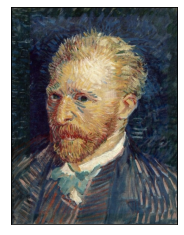

In [7]:
# load content image
content_img = load_and_process_image('1.jpg')
display_image(content_img)

# load style image
style_img = load_and_process_image('style1.jpg')
display_image(style_img)


In [8]:
# define content model
content_layer = 'block5_pool'
content_model = Model(
	inputs=model.input,
	outputs=model.get_layer(content_layer).output
)
content_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [9]:
# define style model
style_layers = [
	'block1_conv1',
	'block3_conv1',
	'block5_conv1'
]
style_models = [Model(inputs=model.input,
					outputs=model.get_layer(layer).output) for layer in style_layers]


In [10]:
# gram matrix
def gram_matrix(A):
	channels = int(A.shape[-1])
	a = tf.reshape(A, [-1, channels])
	n = tf.shape(a)[0]
	gram = tf.matmul(a, a, transpose_a=True)
	return gram / tf.cast(n, tf.float32)


weight_of_layer = 1. / len(style_models)


# style loss
def style_cost(style, generated):
	J_style = 0

	for style_model in style_models:
		a_S = style_model(style)
		a_G = style_model(generated)
		GS = gram_matrix(a_S)
		GG = gram_matrix(a_G)
		current_cost = tf.reduce_mean(tf.square(GS - GG))
		J_style += current_cost * weight_of_layer

	return J_style


In [11]:
# content loss
def content_loss(content,generated):
  a_C = content_model(content)
  a_G = content_model(generated)
  loss = tf.reduce_mean(tf.square(a_C - a_G))
  return loss


In [12]:
# training function
generated_images = []


def training_loop(content_path, style_path, iterations=50, a=10, b=1000):
	# load content and style images from their respective path
	content = load_and_process_image(content_path)
	style = load_and_process_image(style_path)
	generated = tf.Variable(content, dtype=tf.float32)

	opt = tf.keras.optimizers.Adam(learning_rate=7)

	best_cost = math.inf
	best_image = None
	for i in range(iterations):
		# % % time
		with tf.GradientTape() as tape:
			J_content = content_loss(content, generated)
			J_style = style_cost(style, generated)
			J_total = a * J_content + b * J_style

		grads = tape.gradient(J_total, generated)
		opt.apply_gradients([(grads, generated)])

		if J_total < best_cost:
			best_cost = J_total
			best_image = generated.numpy()

		print("Iteration :{}".format(i))
		print('Total Loss {:e}.'.format(J_total))
		generated_images.append(generated.numpy())

	return best_image


In [13]:
# Train the model and get best image
final_img = training_loop('1.jpg', 'style1.jpg')


Iteration :0
Total Loss 6.919449e+11.
Iteration :1
Total Loss 3.426937e+11.
Iteration :2
Total Loss 1.944776e+11.
Iteration :3
Total Loss 1.451960e+11.
Iteration :4
Total Loss 1.140848e+11.
Iteration :5
Total Loss 9.292295e+10.
Iteration :6
Total Loss 8.019823e+10.
Iteration :7
Total Loss 7.153726e+10.
Iteration :8
Total Loss 6.512523e+10.
Iteration :9
Total Loss 6.005075e+10.
Iteration :10
Total Loss 5.537489e+10.
Iteration :11
Total Loss 5.052554e+10.
Iteration :12
Total Loss 4.562639e+10.
Iteration :13
Total Loss 4.107366e+10.
Iteration :14
Total Loss 3.705916e+10.
Iteration :15
Total Loss 3.356491e+10.
Iteration :16
Total Loss 3.053480e+10.
Iteration :17
Total Loss 2.792151e+10.
Iteration :18
Total Loss 2.567166e+10.
Iteration :19
Total Loss 2.374290e+10.
Iteration :20
Total Loss 2.209396e+10.
Iteration :21
Total Loss 2.067023e+10.
Iteration :22
Total Loss 1.942369e+10.
Iteration :23
Total Loss 1.832433e+10.
Iteration :24
Total Loss 1.735817e+10.
Iteration :25
Total Loss 1.650951e+

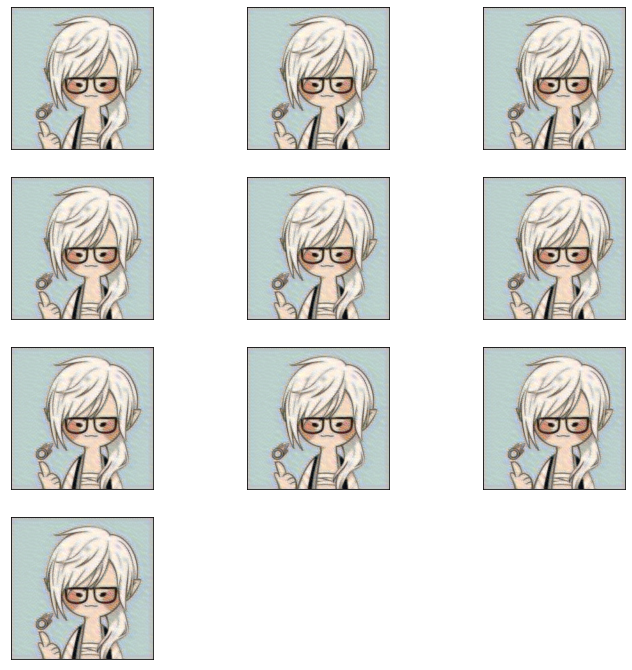

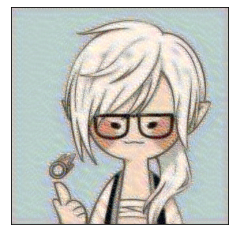

In [14]:
# code to display best generated image and last 10 intermediate results
plt.figure(figsize=(12, 12))

for i in range(10):
	plt.subplot(4, 3, i + 1)
	display_image(generated_images[i+39])
plt.show()

# plot best result
display_image(final_img)
